# Fantasy Data (1970-2023)
This project uses NFL fantasy data from the 1970-2023 seasons (54 seasons total). The 54 CSV files were taken from [Pro Football Reference](https://www.pro-football-reference.com). Each CSV contains all players who were eligible for fantasy scoring in a given season.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# display
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)

# global random_state
random_state = 9

## Combine Data

In [2]:
# get all csv files in the 'data' directory
file_paths = [os.path.join('data/fantasy_seasons', file) for file in os.listdir('data/fantasy_seasons') if file.endswith('.csv')]

The first 22 (1970.csv-1991.csv) don't contain data for recieving targets ('Rec_Tgt' in the dataframe). 

We have to load in the first 22 CSVs, combine the data, and then format the dataframe.

In [3]:
# list to hold first 22 dfs
dfs = []

# read each file into a dataframe
for file_path in file_paths[:22]:
    # get year as string from filename
    year = file_path[-8:-4]
    
    # load each season into a df
    data = pd.read_csv(file_path)

    # make first row the column names
    data.columns = data.loc[0]

    # drop first row
    data = data.drop(0)
    
    # add year column
    data['Year'] = year
    
    # add df to list
    dfs.append(data)

# stack dataframes together
df1 = pd.concat(dfs, axis=0, ignore_index=True)

# add target column
df1['Rec_Tgt'] = np.nan

# drop 'OvRank' column
df1 = df1.drop('OvRank', axis=1)

# rename columns
df1.columns = ['OvrRank', 'Player', 'Tm', 'Pos', 'Age', 'G', 'GS', 'Pass_Cmp', 'Pass_Att', 'Pass_Yds',
       'Pass_TD', 'Pass_Int', 'Rush_Att', 'Rush_Yds', 'Rush_Y/A', 'Rush_TD', 'Rec_Rec', 'Rec_Yds', 'Rec_Y/R', 'Rec_TD',
       'Fmb', 'FmbLost', 'Tot_TD', '2PM', '2PP', 'Standard', 'PPR', 'DraftKings', 'FanDuel', 'VORP',
       'PosRank', 'Key', 'Year', 'Rec_Tgt']

# reorder columns
df1 = df1[['OvrRank', 'Player', 'Tm', 'Pos', 'Age', 'G', 'GS', 'Pass_Cmp', 'Pass_Att', 'Pass_Yds',
       'Pass_TD', 'Pass_Int', 'Rush_Att', 'Rush_Yds', 'Rush_Y/A', 'Rush_TD', 'Rec_Tgt', 'Rec_Rec', 'Rec_Yds', 'Rec_Y/R', 'Rec_TD',
       'Fmb', 'FmbLost', 'Tot_TD', '2PM', '2PP', 'Standard', 'PPR', 'DraftKings', 'FanDuel', 'VORP',
       'PosRank', 'Key', 'Year']]

Now, we can load in the final 32 CSVs (1992.csv-2023.csv) and concatenate them with the first dataframe.

In [4]:
# list to hold final 32 dfs
dfs = []

# read each file into a dataframe
for file_path in file_paths[22:54]:
    # get year as string from filename
    year = file_path[-8:-4]
    
    # load each season into a df
    data = pd.read_csv(file_path)

    # make first row the column names
    data.columns = data.loc[0]

    # drop first row
    data = data.drop(0)
    
    # add year column
    data['Year'] = year
    
    # add df to list
    dfs.append(data)

# stack dataframes together
df2 = pd.concat(dfs, axis=0, ignore_index=True)

# drop 'OvRank' column
df2 = df2.drop('OvRank', axis=1)

# rename columns
df2.columns = ['OvrRank', 'Player', 'Tm', 'Pos', 'Age', 'G', 'GS', 'Pass_Cmp', 'Pass_Att', 'Pass_Yds',
       'Pass_TD', 'Pass_Int', 'Rush_Att', 'Rush_Yds', 'Rush_Y/A', 'Rush_TD', 'Rec_Tgt', 'Rec_Rec', 'Rec_Yds', 'Rec_Y/R', 'Rec_TD',
       'Fmb', 'FmbLost', 'Tot_TD', '2PM', '2PP', 'Standard', 'PPR', 'DraftKings', 'FanDuel', 'VORP',
       'PosRank', 'Key', 'Year']

In [5]:
# create master df
df = pd.concat([df1, df2], axis=0, ignore_index=True)
del df1, df2, dfs

## Add Columns

In [6]:
# convert numeric cols to numeric
df = df.apply(pd.to_numeric, errors='ignore')

In [7]:
# drop some columns we won't use
df = df.drop(columns=['Tot_TD', 'DraftKings', 'FanDuel'])

# add Scrimmage Yds and TD
df['Scrim_Yds'] = df['Rush_Yds'] + df['Rec_Yds']
df['Scrim_TD'] = df['Rush_TD'] + df['Rec_TD']

In [8]:
# assign default value
df['num_games'] = 0

# assign 16 games for seasons before 2021, 17 games for seasons later
df.loc[df['Year'] < 2021, 'num_games'] = 16
df.loc[df['Year'] >= 2021, 'num_games'] = 17

# use the games played to assess if a player has been injured
df['games_played_pct'] = df['G'] / df['num_games']
df['games_started_pct'] = df['GS'] / df['G']
df['games_started_pct'] = df['games_started_pct'].fillna(0)

In [9]:
# view df
df.head()

,OvrRank,Player,Tm,Pos,Age,G,GS,Pass_Cmp,Pass_Att,Pass_Yds,Pass_TD,Pass_Int,Rush_Att,Rush_Yds,Rush_Y/A,Rush_TD,Rec_Tgt,Rec_Rec,Rec_Yds,Rec_Y/R,Rec_TD,Fmb,FmbLost,2PM,2PP,Standard,PPR,VORP,PosRank,Key,Year,Scrim_Yds,Scrim_TD,num_games,games_played_pct,games_started_pct
0,1,Ron Johnson*+,NYG,RB,23,14,14,0,0,0,0,0,263,1027,3.90,8,NaN,48,487,10.15,4,5.0,NaN,NaN,NaN,218.0,266.4,135.0,1,JohnRo02,1970,1514,12,16,0.8750,1.000000
1,2,Gene Washington*+,SFO,WR,23,13,13,0,0,0,0,0,0,0,NaN,0,NaN,53,1100,20.75,12,0.0,NaN,NaN,NaN,182.0,235.0,134.0,1,WashGe00,1970,1100,12,16,0.8125,1.000000
2,3,MacArthur Lane*,STL,FB,28,14,14,0,0,0,0,0,206,977,4.74,11,NaN,32,365,11.41,2,2.0,NaN,NaN,NaN,210.0,242.2,126.0,2,LaneMa00,1970,1342,13,16,0.8750,1.000000
3,4,Warren Wells*,OAK,WR,28,14,13,0,0,0,0,0,3,34,11.33,0,NaN,43,935,21.74,11,0.0,NaN,NaN,NaN,163.0,205.9,112.0,2,WellWa00,1970,969,11,16,0.8750,0.928571
4,5,John Brodie*+,SFO,QB,35,14,14,223,378,2941,24,10,9,29,3.22,2,NaN,0,0,NaN,0,1.0,NaN,NaN,NaN,208.0,207.5,105.0,1,BrodJo00,1970,29,2,16,0.8750,1.000000


We can see that the 'Player' column contains the special characters '*' and '+'. These are used to indicate Pro Bowl and All-Pro selections respectively.

In [10]:
# add 'ProBowl' column if '*' in 'Player'
df['ProBowl'] = df['Player'].apply(lambda x: True if '*' in x else False)

# add 'AllPro' column if '+' in 'Player'
df['AllPro'] = df['Player'].apply(lambda x: True if '+' in x else False)

# remove '*' and '+' from 'Player' column
df['Player'] = df['Player'].apply(lambda x: x.replace('*', '').replace('+', ''))

In [11]:
# look at unique positions
df['Pos'].unique()

array(['RB', 'WR', 'FB', 'QB', 'TE'], dtype=object)

Also, 'FB' position values will be replaced with 'RB', as they both occupy the RB position in fantasy lineups.

In [12]:
# replace FB with RB in 'Pos' column
df['Pos'] = df['Pos'].apply(lambda x: 'RB' if x == 'FB' else x)

Here we will add a feature '__experience__' to represent the player's years of experience. For example, a rookie player would have exp=0.

First, we need to estimate experience for the 1970 players. Most of these players are not rookies. After manually inspecting the 1970 season on [Pro Football Reference](https://www.pro-football-reference.com/years/1970/fantasy.htm), it seems like the majority of rookies in that season were __22 years old__. This makes sense (4 years of college was the norm back then). Thus, we will assume that 1970 players were 22 their rookie season in order to estimate their years of experience.

In [13]:
# create column 'exp' for years of experience
df['Exp'] = np.nan

# estimate value
rookie_age = 22

# 'exp' for 1970 players will be 'Age' - 22
df.loc[df['Year'] == 1970, 'Exp'] = df.loc[df['Year'] == 1970, 'Age'] - rookie_age

# check
df.loc[df['Year'] == 1970, ['Player', 'Age', 'Exp']].head()

,Player,Age,Exp
0,Ron Johnson,23,1.0
1,Gene Washington,23,1.0
2,MacArthur Lane,28,6.0
3,Warren Wells,28,6.0
4,John Brodie,35,13.0


In [14]:
# function to fill in experience column
def fill_experience(group):
    # get first experience value for a player
    first_exp = group['Exp'].iloc[0]
    
    # if value is null, set to 0 (rookie season)
    if pd.isna(first_exp):
        first_exp = 0
    
    # define range of years to fill each player's experience column
    experience = range(int(first_exp), int(first_exp) + len(group))
    group['Exp'] = list(experience)
    return group

# ensure we are sorted by year
df = df.sort_values('Year')

# group by unique player identifier 'Key' and fill experience values
df = df.groupby('Key').apply(fill_experience).reset_index(drop=True)

# check
df[df['Player'] == 'Patrick Mahomes'][['Player', 'Year', 'Exp']]

,Player,Year,Exp
24302,Patrick Mahomes,2017,0
25285,Patrick Mahomes,2018,1
25946,Patrick Mahomes,2019,2
26550,Patrick Mahomes,2020,3
27234,Patrick Mahomes,2021,4
27887,Patrick Mahomes,2022,5
28574,Patrick Mahomes,2023,6


Now we have __experience__ as a feature.

Next, we want add a flag to indicate if a player is on a __new team__ in a given season. Some players have success when transitioning to a new team, and some don't. Ideally, we can use this column as a feature when predicting 2024 fantasy points for the 2023 players that have switched teams.

Before creating this flag, we must clean the "Tm" (team) column. For seasons where a player played for multiple teams ("Tm" col contains '2TM', '3TM', etc), we will reset the "Tm" value to be the team that the player played for in the previous season. This conversion will be slightly innacurate for the few rookies that played for multiple teams in their first season, but their are no notable fantasy seasons in this subset anyway.

 We will add a 'New_Team' flag to mark rows where the player switched teams. We will later use this column for analysis. We will also add a 'Will_be_on_New_Team' flag to mark the rows BEFORE the player switched teams.

In [15]:
# add columns
df['New_Team'] = False
df['Will_be_on_New_Team'] = False

# group by player
player_group = df.groupby('Key')

# iterate through each player
for player, data in player_group:

    # calculate if a player switched teams in the next year, update the 'New_Team' column
    switched_team = (data['Tm'] != data['Tm'].shift(1)) & (~data['Tm'].str.contains('TM'))
    df.loc[switched_team.index, 'New_Team'] = switched_team.astype(bool)

    # set 'New_Team' to 0 for the player's first row in the group
    df.loc[data.index[0], 'New_Team'] = False

    # create 'Will_be_on_New_Team' by shifting 'New_Team' within each player's data
    df.loc[data.index, 'Will_be_on_New_Team'] = switched_team.shift(-1).fillna(False).astype(bool)

# Correct the shift of the 'Will_be_on_New_Team' column
df['Will_be_on_New_Team'] = player_group['New_Team'].shift(-1).fillna(False).astype(bool)

In [16]:
# view
df[df['Player'] == 'Christian McCaffrey'][['Player', 'Year', 'Tm', 'New_Team', 'Will_be_on_New_Team']]

,Player,Year,Tm,New_Team,Will_be_on_New_Team
24712,Christian McCaffrey,2017,CAR,False,False
25283,Christian McCaffrey,2018,CAR,False,False
25899,Christian McCaffrey,2019,CAR,False,False
26709,Christian McCaffrey,2020,CAR,False,False
27186,Christian McCaffrey,2021,CAR,False,False
27889,Christian McCaffrey,2022,2TM,False,True
28524,Christian McCaffrey,2023,SFO,True,False


__New_team__ has been flagged successfully. 

There are still 'Tm' values that indicate that a player was traded in a given season (2TM in the 'Tm' column seen above). We will add a 'Traded' boolean column that we can later use for analysis. We will then fill these values with the team that the player started the season on. This is so that we can analyze team stacks over the years in this [notebook](stacking.ipynb). For players who were traded in their rookie season, we don't have the 'Tm' value for the previous season. These 'Tm' values will be filled with the team that the player played for in the following season.

In [17]:
# look at 'Tm' col where it contains 'TM'
df[df['Tm'].str.contains('TM')].Tm.unique()

array(['2TM', '3TM', '4TM'], dtype=object)

In [18]:
# create 'Traded' boolean column if 'Tm' contains 'TM'
df['Traded'] = df['Tm'].str.contains('TM').astype(bool)

# check
df[df['Traded'] == True][['Player', 'Year', 'Tm', 'Traded']].head()

,Player,Year,Tm,Traded
11,Dick Davis,1970,2TM,True
29,Claxton Welch,1970,2TM,True
97,Jim McFarland,1970,2TM,True
140,Roland Moss,1970,2TM,True
174,Bob Gladieux,1970,2TM,True


In [19]:
# handle rookies who were traded
rookie_trades = df[(df['Exp'] == 0) & (df['Traded'] == True)]
for index, row in rookie_trades.iterrows():
    next_season_team = df.loc[index + 1, 'Tm']
    df.at[index, 'Tm'] = next_season_team

# handle multi-team seasons for non-rookies
multi_team_seasons = df[df['Traded'] == True]
for index, row in multi_team_seasons.iterrows():
    previous_team = df.loc[index - 1, 'Tm']
    df.at[index, 'Tm'] = previous_team

# check
df[df['Traded'] == True][['Player', 'Year', 'Tm', 'Traded']].head()

,Player,Year,Tm,Traded
11,Dick Davis,1970,WAS,True
29,Claxton Welch,1970,CIN,True
97,Jim McFarland,1970,HOU,True
140,Roland Moss,1970,WAS,True
174,Bob Gladieux,1970,PHI,True


## Handle Null Values

In [20]:
# view nulls
df.isnull().sum().to_frame().T

,OvrRank,Player,Tm,Pos,Age,G,GS,Pass_Cmp,Pass_Att,Pass_Yds,Pass_TD,Pass_Int,Rush_Att,Rush_Yds,Rush_Y/A,Rush_TD,Rec_Tgt,Rec_Rec,Rec_Yds,Rec_Y/R,Rec_TD,Fmb,FmbLost,2PM,2PP,Standard,PPR,VORP,PosRank,Key,Year,Scrim_Yds,Scrim_TD,num_games,games_played_pct,games_started_pct,ProBowl,AllPro,Exp,New_Team,Will_be_on_New_Team,Traded
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13000,0,11228,0,0,7887,0,1923,18163,27658,28176,3611,2981,24799,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
# view 2-point conversion columns
df[['2PM', '2PP']].describe().T

,count,mean,std,min,25%,50%,75%,max
2PM,1082.0,1.127542,0.385202,1.0,1.0,1.0,1.0,4.0
2PP,564.0,1.512411,0.850152,1.0,1.0,1.0,2.0,8.0


2-point conversion data is missing prior to 1994, and since it has a very little impact on fantasy scoring (1 2pt conversion per player on average), we will drop these columns here.

We will be recalculating the point-related columns, so we will drop them here as well.

In [22]:
# drop 2pt conversion cols and the cols we are recalculating
df = df.drop(columns=['2PM', '2PP', 'OvrRank', 'PosRank', 'Standard', 'PPR', 'VORP'])

- Rush_Y/A can simply be calulcated: (Rush_Yds / Rush_Att).
- Rec_Y/R can also be calculated: (Rec_Yds / Rec_Rec).

In [23]:
# recalculate per-attempt stats
df['Pass_Y/A'] = (df['Pass_Yds'] / df['Pass_Att']).fillna(0)
df['Rush_Y/A'] = (df['Rush_Yds'] / df['Rush_Att']).fillna(0)
df['Rec_Y/R'] = (df['Rec_Yds'] / df['Rec_Rec']).fillna(0)

Rec_Tgt is challenging to estimate for the players prior to 1992. To estimate # of targets for the players from 1970-1991, we first need to estimate the __catch rate__ (Receptions / Targets) for a given season. To do this, we can inspect the catch rates of other seasons.

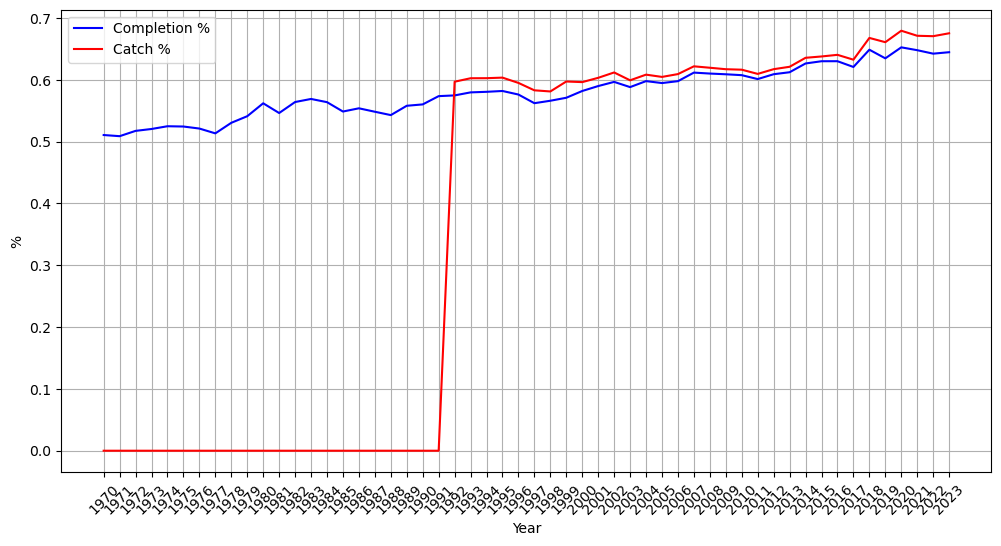

In [24]:
# initialize some lists
catch_rates = []
cmp_rates = []
years = []
diffs = []

# iterate through seasons
for (year, data) in df.groupby('Year'):
    # get catch rate for the season
    total_rec = data['Rec_Rec'].sum()
    total_tgt = data['Rec_Tgt'].sum()
    catch_rate = total_rec / total_tgt if total_tgt > 0 else 0

    # get completion percentage for the season
    total_cmp = data['Pass_Cmp'].sum()
    total_att = data['Pass_Att'].sum()
    cmp_rate = total_cmp / total_att if total_att > 0 else 0

    # calc diff
    diff = catch_rate - cmp_rate

    # append to lists
    catch_rates.append(catch_rate)
    cmp_rates.append(cmp_rate)
    years.append(year)
    diffs.append(diff)

# Plot rates
plt.figure(figsize=(12, 6))
plt.xticks(range(len(years)), years, rotation=45)
plt.plot(cmp_rates, color='blue', label='Completion %')
plt.plot(catch_rates, color='red', label='Catch %')
plt.xlabel('Year')
plt.ylabel('%')
plt.grid(True)
plt.legend()
plt.show()

- Catch rate has steadily rose from 60% to 67% in the last 10-15 years due to the more pass heavy offenses we see today. However, from 1992-2006, catch rates were steadily around __60%__.
- Completion percentage is always slightly lower than catch rate (due to balls thrown away, blocked passes, and spikes). We will also inspect the differences between catch rate and completion percentage for 1992-2023:

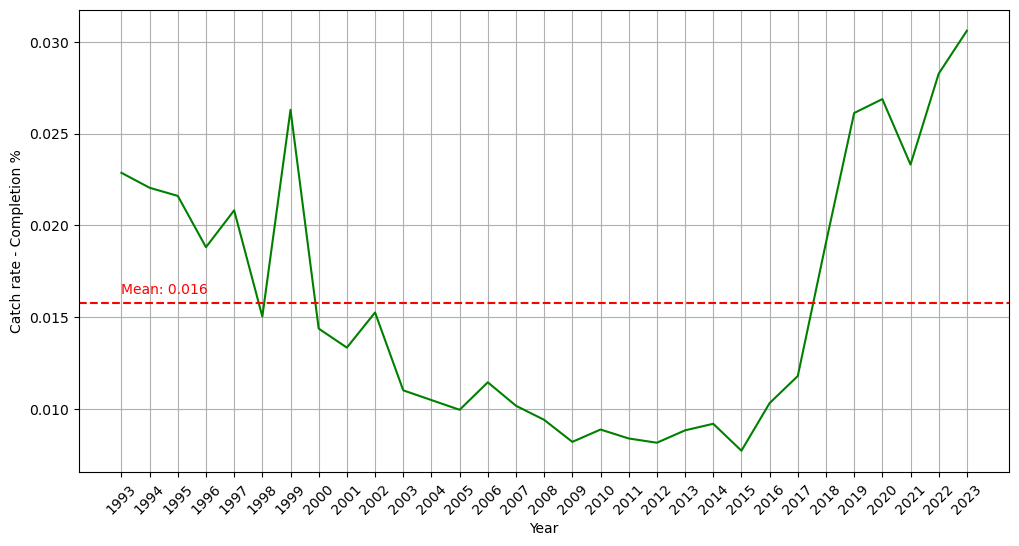

In [25]:
# view diffs
plt.figure(figsize=(12, 6))
plt.xticks(range(len(years[23:])), years[23:], rotation=45)
plt.plot(diffs[23:], color='green')
plt.xlabel('Year')
plt.ylabel('Catch rate - Completion %')
plt.grid(True)

# plot mean
plt.axhline(y=np.mean(diffs[23:]), color='r', linestyle='--')
plt.text(0, np.mean(diffs[23:]) + 0.0005, 'Mean: {:.3f}'.format(np.mean(diffs[23:])), color='r')
plt.show()

In [26]:
# mean of diffs
mean_diff = np.mean(diffs[23:])
mean_diff

0.015758887546098686

The mean differential is around __1.5%__. I will add this value to the completion percentage for the 1970-1991 seasons to estimate the __catch rate__. We will assume this catch rate for every player with a recorded reception. Then, we can divide each player's receptions by the catch rate to get __total targets__.

In [27]:
# iterate through seasons before 1992
for (year, data) in df.loc[df['Year'] < 1992].groupby('Year'):

    # get completion percentage for the season
    total_cmp = data['Pass_Cmp'].sum()
    total_att = data['Pass_Att'].sum()
    cmp_rate = total_cmp / total_att

    # calculate catch rate
    catch_rate = cmp_rate + mean_diff

    # fill 'Rec_Tgt' column by dividing receptions by catch rate
    df.loc[df['Year'] == year, 'Rec_Tgt'] = df.loc[df['Year'] == year, 'Rec_Rec'] / catch_rate

# fill rest (recievers with 0 receptions) with 0
df['Rec_Tgt'] = df['Rec_Tgt'].fillna(0)

- Since we have fumble data for all years, null Fmb (fumbles) will be filled with 0.
- Prior to 1994 we have no FmbLost. We can estimate this by calculating the average fumbles lost % for each given season.

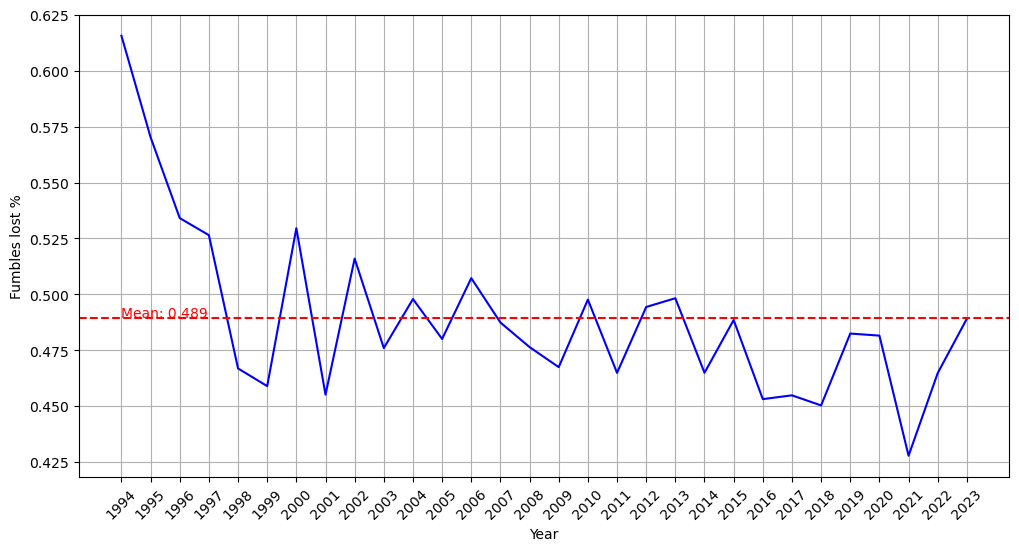

In [28]:
# fill fumbles with 0
df['Fmb'] = df['Fmb'].fillna(0)

# list for plotting
rates = []

# iterate through seasons
for (year, data) in df.loc[df['Year'] >= 1994].groupby('Year'):
    # get fumbles lost % for the season
    total_fmb = data['Fmb'].sum()
    total_fmb_lost = data['FmbLost'].sum()
    fmb_rate = total_fmb_lost / total_fmb

    # append to list
    rates.append(fmb_rate)

# plot rates
plt.figure(figsize=(12, 6))
plt.xticks(range(len(years[24:])), years[24:], rotation=45)
plt.plot(rates, color='blue')
plt.xlabel('Year')
plt.ylabel('Fumbles lost %')
plt.grid(True)

# plot mean
mean_rate = np.mean(rates)
plt.axhline(y=mean_rate, color='r', linestyle='--')
plt.text(0, mean_rate + 0.0005, 'Mean: {:.3f}'.format(mean_rate), color='r')
plt.show()

In [29]:
# mean of diffs
mean_rate

0.4892731811462555

We can see that the mean fumbles lost rate is about __49%__ from 1994-2023. Reading the plot right-to-left, it seems to be trending upward past 60% (as if prior seasons lost fumbles at a higher rate). I feel like using __55%__ as the estimate is a good middleground.

In [30]:
# fumble rate
fumble_rate = 0.55

# iterate through seasons before 1992
for (year, data) in df.loc[df['Year'] < 1994].groupby('Year'):

    # fill 'FmbLost' column by multiplying fumbles by fumble rate (55%)
    df.loc[df['Year'] == year, 'FmbLost'] = df.loc[df['Year'] == year, 'Fmb'] * fumble_rate

# fill rest (players with 0 fumbles) with 0
df['FmbLost'] = df['FmbLost'].fillna(0)

In [31]:
# view nulls once more
df.isnull().sum().sum()

0

Now, all null values have been filled.

## Volume
Now, we will add a 'Touches' column (sum of Passing, Rushing, and Receiving Attempts) to reflect the amount of volume a player had in a given season:

In [32]:
# add 'Touches' column
df['Touches'] = (df['Pass_Att'] + df['Rush_Att'] + df['Rec_Rec']).fillna(0)

## Efficiency
Now, we will add columns to reflect the efficiency a player had in a given season:
- Completion % (Pass Completions / Pass Attempts)
- Catch Rate (Receptions / Targets)

In [33]:
# add 'Cmp%' column
df['Cmp%'] = (df['Pass_Cmp'] / df['Pass_Att']).fillna(0)

In [34]:
# add 'Catch%' column
df['Catch%'] = (df['Rec_Rec'] / df['Rec_Tgt']).fillna(0)

## Per-Game Stats
We will also add normalized stats on a per-game basis.

In [35]:
# statistical columns to be normalized
stats_words = ['Pass', 'Rush', 'Rec', 'Fmb', 'Scrim', 'Touches']
stats_cols = [col for col in df.columns if any(word in col for word in stats_words) and col not in ['Pass_Y/A', 'Rush_Y/A', 'Rec_Y/R']]

# normalize stats columns per game
for col in stats_cols:
    df[col + '_per_game'] = df[col] / df['G']

## __Points__ and __Rankings__
We will add point columns for 4 different formats:
- __Standard__
- __Half-point PPR__
- __PPR__
- __6-point passing TDs__

We will also add __per-game__ and __per-touch__ columns for each of the 4 scoring formats. Both __overall ranks__ and __positional ranks__ will also be added here.

In [36]:
# calculate standard points
df['Points_standard'] = (df['Pass_Yds'] * 0.04) + (df['Pass_TD'] * 4) + (df['Pass_Int'] * -2) + \
    (df['Rush_Yds'] * 0.1) + (df['Rush_TD'] * 6) + \
    (df['Rec_Yds'] * 0.1) + (df['Rec_TD'] * 6) + \
    (df['FmbLost'] * -2)

# calculate half-ppr points
df['Points_half-ppr'] = df['Points_standard'] + (df['Rec_Rec'] * 0.5)

# calculate ppr points
df['Points_ppr'] = df['Points_standard'] + (df['Rec_Rec'] * 1)

# for my Yahoo league: 6pt pass TD, -1 pass int
df['Points_6'] = (df['Pass_Yds'] * 0.04) + (df['Pass_TD'] * 6) + (df['Pass_Int'] * -1) + \
    (df['Rush_Yds'] * 0.1) + (df['Rush_TD'] * 6) + \
    (df['Rec_Rec'] * 1) + (df['Rec_Yds'] * 0.1) + (df['Rec_TD'] * 6) + \
    (df['FmbLost'] * -2)

In [37]:
# list for scoring
scoring = ['standard', 'half-ppr', 'ppr', '6']

# add 'PPG' columns
for scoring_type in scoring:
    df['PPG_' + scoring_type] = (df['Points_' + scoring_type] / df['G']).fillna(0)

# add 'PPT' columns
for scoring_type in scoring:
    df['PPT_' + scoring_type] = (df['Points_' + scoring_type] / df['Touches']).fillna(0)

In [38]:
# some groups we will be using
year_groups = df.groupby('Year')
pos_groups = df.groupby(['Year', 'Pos'])

# add seasonal rankings for each year group
for scoring_type in scoring:
    df['SeasonOvrRank_' + scoring_type] = year_groups['Points_' + scoring_type].transform(lambda x: x.rank(ascending=False, method='min'))

# add seasonal rankings for each position group
for scoring_type in scoring:
    df['SeasonPosRank_' + scoring_type] = pos_groups['Points_' + scoring_type].transform(lambda x: x.rank(ascending=False, method='min'))

# add ppg rankings for each year group
for scoring_type in scoring:
    df['PPGOvrRank_' + scoring_type] = year_groups['PPG_' + scoring_type].transform(lambda x: x.rank(ascending=False, method='min'))

# add ppg rankings for each position group
for scoring_type in scoring:
    df['PPGPosRank_' + scoring_type] = pos_groups['PPG_' + scoring_type].transform(lambda x: x.rank(ascending=False, method='min'))

# add ppt rankings for each year group
for scoring_type in scoring:
    df['PPTOvrRank_' + scoring_type] = year_groups['PPT_' + scoring_type].transform(lambda x: x.rank(ascending=False, method='min'))

# add ppt rankings for each position group
for scoring_type in scoring:
    df['PPTPosRank_' + scoring_type] = pos_groups['PPT_' + scoring_type].transform(lambda x: x.rank(ascending=False, method='min'))

# cast all ranking columns to int
rank_cols = [col for col in df.columns if 'Rank' in col]

### Value over Replacement Player
In a 10-team league with the rosters:
- 1 QB
- 2 RB
- 2 WR
- 1 TE
- 1 RB/WR/TE
- 1 DEF
- 1 K

Thus, the replacement players are:
- QB10
- RB25 (assuming half the flex spots are RBs)
- WR25 (assuming half the flex spots are WRs)
- TE10

Here, I will also calculate the VORP for 12 team and 3WR leagues.

In [41]:
# define the replacement rank based on league
replacement_ranks_10 = {
    'QB': 10,
    'RB': 25,
    'WR': 25,
    'TE': 10
}
replacement_ranks_12 = {
    'QB': 12,
    'RB': 30,
    'WR': 30,
    'TE': 12
}

replacement_ranks_10_3WR = {
    'QB': 10,
    'RB': 25,
    'WR': 35,
    'TE': 10
}

replacement_ranks_12_3WR = {
    'QB': 12,
    'RB': 30,
    'WR': 42,
    'TE': 12
}

# iterate through the position groups
for (year, pos), group in pos_groups:

    # iterate through the replacement ranks
    for replacement_ranks, col_name in [(replacement_ranks_10, '10tm'), (replacement_ranks_12, '12tm'), (replacement_ranks_10_3WR, '10tm_3WR'), (replacement_ranks_12_3WR, '12tm_3WR')]:

        # iterate for both seasonal and PPG VORP
        for rank_type in ['Points', 'PPG']:

            # get the replacement rank for the current position, subtract 1 to get the index
            rank = int(replacement_ranks[pos] - 1)

            # iterate through the scoring types
            for scoring_type in scoring:

                # sort group
                group = group.sort_values(rank_type + '_' + scoring_type, ascending=False)

                # get replacement player points for the current position and scoring type
                replacement = group.iloc[rank][rank_type + '_' + scoring_type]

                # add VORP column
                df.loc[(df['Year'] == year) & (df['Pos'] == pos), rank_type + '_' + 'VORP_' + scoring_type + '_' + col_name] = df.loc[(df['Year'] == year) & (df['Pos'] == pos), rank_type + '_' + scoring_type] - replacement

In [42]:
# view top QB and replacement QB of 2023 (10 team, standard scoring)
df.loc[(df['Year'] == 2023) & (df['Pos'] == 'QB'), ['Player', 'Year', 'Points_standard', 'Points_VORP_standard_10tm', 'PPG_VORP_standard_10tm']].sort_values('Points_standard', ascending=False).head(10)

,Player,Year,Points_standard,Points_VORP_standard_10tm,PPG_VORP_standard_10tm
28526,Josh Allen,2023,386.64,116.28,4.698529
28528,Jalen Hurts,2023,356.82,86.46,2.944412
28539,Dak Prescott,2023,338.84,68.48,1.886765
28533,Lamar Jackson,2023,329.22,58.86,2.531250
28520,Jordan Love,2023,315.06,44.70,0.487941
28515,Brock Purdy,2023,295.60,25.24,0.430000
28564,Jared Goff,2023,285.10,14.74,-1.274412
28574,Patrick Mahomes,2023,280.22,9.86,-0.531250
28550,C.J. Stroud,2023,273.02,2.66,0.156333
28551,Tua Tagovailoa,2023,270.36,0.00,-2.141471


We can see that Josh Allen is the top QB of 2023. Tua is the replacement level QB at rank #10. Allen's VORP is simply how many more points he scored than Tua in that season. This stat is useful for identifying player value.

In [43]:
# view top QB and replacement QB of 2023 (10 team, 6pt passing TDs)
df.loc[(df['Year'] == 2023) & (df['Pos'] == 'QB'), ['Player', 'Year', 'Points_6', 'Points_VORP_6_10tm', 'PPG_VORP_6_10tm']].sort_values('Points_6', ascending=False).head(10)

,Player,Year,Points_6,Points_VORP_6_10tm,PPG_VORP_6_10tm
28526,Josh Allen,2023,462.64,126.58,5.546118
28539,Dak Prescott,2023,419.84,83.78,3.028471
28528,Jalen Hurts,2023,417.82,81.76,2.909647
28520,Jordan Love,2023,390.06,54.00,1.276706
28533,Lamar Jackson,2023,384.22,48.16,2.345750
28515,Brock Purdy,2023,368.60,32.54,1.369500
28564,Jared Goff,2023,357.10,21.04,-0.662118
28574,Patrick Mahomes,2023,348.22,12.16,0.095750
28551,Tua Tagovailoa,2023,342.36,6.30,-1.529176
28544,Baker Mayfield,2023,336.06,0.00,-1.899765


With 6pt passing TDs, mobile QBs (Hurts and Lamar) fall a bit. High volume passers (Prescott, Love) are slightly more valuable.

## Target Variable
The target will be the player's fantasy points for the next season.

In [44]:
# add seasonal target cols
for scoring_type in scoring:
    # group by each player and shift the points column by 1
    df['SeasonTarget_' + scoring_type] = df.groupby('Key')['Points_' + scoring_type].shift(-1)

# add ppg target cols
for scoring_type in scoring:
    # group by each player and shift the points column by 1
    df['PPGTarget_' + scoring_type] = df.groupby('Key')['PPG_' + scoring_type].shift(-1)

# check
df[df['Player'] == 'Josh Allen'][['Player', 'Year', 'Exp', 'Points_ppr', 'PPG_ppr', 'SeasonTarget_ppr', 'PPGTarget_ppr']]

,Player,Year,Exp,Points_ppr,PPG_ppr,SeasonTarget_ppr,PPGTarget_ppr
25208,Josh Allen,2018,0,206.06,17.171667,282.56,17.660000
25941,Josh Allen,2019,1,282.56,17.660000,396.06,24.753750
26547,Josh Allen,2020,2,396.06,24.753750,396.58,23.328235
27226,Josh Allen,2021,3,396.58,23.328235,391.52,24.470000
27892,Josh Allen,2022,4,391.52,24.470000,386.64,22.743529
28526,Josh Allen,2023,5,386.64,22.743529,NaN,NaN


In [45]:
# save master file
df.to_csv('data/final_data/master.csv', index=False)